In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import saildrone_processing
from front_detection import detect_grad_1d
import functions
import numpy as np
import pandas as pd
from functions import import_cmems
import matplotlib as mpl

In [28]:
def match_obs_alt(altimeter, lon_sdrn, lat_sdrn, threshold = 2*1e-6):
    ''' Match the position of the peaks in SSH grad with the position of the in situ observation
    Writers: Felipe Vilela da Silva and Alessio Arena
    ==============================================================================
    INPUTS:
    
    OUTPUTS:
    '''
    
    if ~np.isnan(lat_sdrn):
        ## Next, I extract the altimeter information nearby the in situ observation
        alt_at_obs = altimeter.sel(latitude = slice(lat_sdrn-1, lat_sdrn+1), 
                                   longitude = slice(lon_sdrn-1,lon_sdrn+1))

        # TODO: if interested, find a more accurate way to convert deg to m
        # we have first followed the latitudinal and longitudinal distances but it only worked
        # if we turned the xarray into a np.array. We preferred to keep it as a xarray atm.
        deg_to_m = 111195.
        var_x = alt_at_obs.differentiate('longitude')/deg_to_m
        var_y = alt_at_obs.differentiate('latitude')/deg_to_m
        ## Below, I compute the module of the gradient 
        gradient = np.sqrt(var_x**2 + var_y**2)

        grad_thld   = gradient.where(gradient > threshold)
        grad_at_obs = grad_thld.sel(latitude=lat_sdrn.data, longitude=lon_sdrn.data, 
                                    method = 'nearest').data.item()
    
        return ~np.isnan(grad_at_obs)
    else:
        return False

## Importing Saildrone and CMEMS data

In [2]:
ds_saildrone = xr.open_mfdataset("~/shared/antarctic_sd_data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc", chunks='auto')

In [3]:
variables = [
    'TEMP_CTD_RBR_STDDEV',
    'TEMP_CTD_RBR_MEAN',
    'SAL_RBR_MEAN',
    'SAL_RBR_STDDEV',
    'O2_CONC_AANDERAA_MEAN',
    'O2_CONC_AANDERAA_STDDEV',
    'CHLOR_RBR_MEAN',
    'CHLOR_RBR_STDDEV']

# gdf = saildrone_processing.prepare_data(ds_saildrone, variables, aggregate_method='mean', 
#                                         resample_to='1440Min')
gdf = saildrone_processing.prepare_data(ds_saildrone, variables, aggregate_method='mean', 
                                        resample_to='720Min')

In [ ]:
distance = functions.distFromStart(lat_sdrn.values, lon_sdrn.values)
gdf_dist = gdf.copy()
gdf_dist['distance_km'] = distance

In [4]:
lat_sdrn  = gdf.latitude
lon_sdrn  = gdf.longitude
time_sdrn = gdf.time

In [40]:
## # Importing the variable from CMEMS
# Remember that once the credentials are used, you will need to change your password at CMEMS
# it is a bug to be solved in this function
# cmems_data = import_cmems('adt', 
#       'https://my.cmems-du.eu/thredds/dodsC/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D', 
#       'username', 'password', -180, 180, -65, -45, '2019-01-01', '2020-01-01')

# The Function

In [57]:
def front_finder(altimeter, lon_sdrn, lat_sdrn, time_sdrn,
                 saild, var, criterion, 
                 threshold = 2*1e-6, x_bin = 500, min_obs = None, method = 'jet_front'):
    ''' Identifying fronts using altimeter and in situ observations. 
    First, the algorithm tracks the in situ measurements located within peaks in gradients of 
    altimeter observations (e.g., SSH). It gives the initial condition for the position of mesoscale
    fronts. Then, it computes level of strength in the gradients of the chosen value from the in situ 
    observation.    
    ================================================================================================
    INPUT:
       altimeter = adt, sla, etc [time, n, m]
       lon_sdrn  = longitude array of the in sity obs [n]
       lat_sdrn  = latitude array of the in sity obs [m]
       time_sdrn = time array of the in sity obs [t]
       saild     = the data of the in in situ observations. 
                   It must contain a column named 'distance_km' with 
                   the distance between each sampling
       var       = variable name (string), to compute the gradient (e.g. Temperature, Salinity, 
                   Chlorophyll, Density)
       criterion = gradient criterion to group fronts into different levels (list of 5 values)
       method    = 'jet_front' uses both the defition to identify jets and fronts
                   'front_grad' identifies frontal filaments.  
    OUTPUT:
       The in situ dataset with the variables at the position of the identified fronts
    ================================================================================================
    Writers: Alessio Arena, Felipe Vilela da Silva, Mackenzie Blanusa, Maya Jakes and Sophie Clayton
    '''    
    if method == 'jet_front':
        # When does the position of the in situ observation coincide with the peaks in SSH gradient 
        # from the altimeter?
        boolean_pos = np.ravel([np.array(match_obs_alt(altimeter.sel(time=str(time_sdrn[t]), method = 'nearest'), 
                                                     lon_sdrn[t], lat_sdrn[t]))
                                for t in range(len(saild))])

        # What is the strength the SST from the in situ observation at these locations?
        saild_gradSSH = saild.loc[boolean_pos].copy()
        front_level = detect_grad_1d(saild_gradSSH, var, criterion, x_bin = x_bin, min_obs = min_obs)
        return front_level
    elif method == 'front_grad':
        front_level = detect_grad_1d(saild, var, criterion, x_bin = x_bin, min_obs = min_obs)
        return front_level

In [64]:
a = front_finder(cmems_data, lon_sdrn, lat_sdrn, time_sdrn,
             gdf_dist, var, criterion, x_bin = 500, min_obs = False, method = 'jet_front')

(-180.0, 180.0)

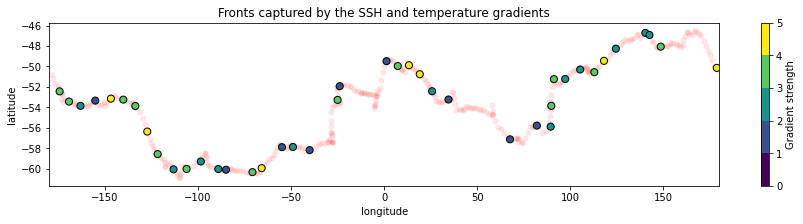

In [65]:
fig, ax = plt.subplots(figsize = (15,3))

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0, len(criterion)+1, 1), cmap.N)

plt.scatter(gdf_dist.longitude, gdf_dist.latitude, c = 'r', label = 'no SSH grad', alpha = .1,
            edgecolors = 'w')
plt.scatter(a.longitude, a.latitude, c = a.level, norm = norm, s = 50,
            edgecolors = 'k')

# CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Gradient strength', ticks = np.arange(0, len(criterion)+1, 1))
plt.title('Fronts captured by the SSH and temperature gradients')
plt.xlim(-180,180)

In [ ]:
# %time
# bol_pos_first = np.ravel([np.array(match_obs_alt(cmems_data.sel(time=str(time_sdrn[t]), method = 'nearest'), 
#                                                  gdf.longitude[t], gdf.latitude[t]))
#                          for t in range(len(gdf))])

## First version of the algorithm below

## Detect regions of high gradients in the Saildrone data (e.g., SST)
--> It will return the regions where the in situ observations capture fronts in smaller scales

In [ ]:
distance = functions.distFromStart(lat_sdrn.values, lon_sdrn.values)
gdf_dist = gdf.copy()
gdf_dist['distance_km'] = distance

In [ ]:
# input the data variable that you want to find fronts with
var = 'TEMP_CTD_RBR_MEAN'

# TO DO: Discuss what criterion we should use for different variables.
# criterion = [0.01, 0.05, 0.25, 0.75, 1] 
criterion = [0, 0.001, 0.0025, 0.005, 0.01] 

temp_fronts = detect_grad_1d(gdf_dist, var, criterion, x_bin = 500, min_obs = False)

(-180.0, 180.0)

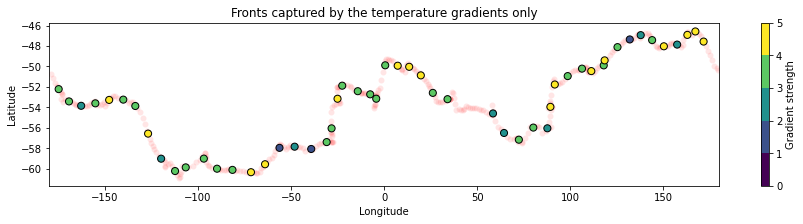

In [7]:
fig, ax = plt.subplots(figsize = (15,3))

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0, len(criterion)+1, 1), cmap.N)


plt.scatter(gdf_dist.longitude, gdf_dist.latitude, c = 'r', label = 'no SSH grad', alpha = .1,
            edgecolors = 'w')
plt.scatter(temp_fronts.longitude, temp_fronts.latitude, c = temp_fronts.level, norm = norm, s = 50,
            edgecolors = 'k')

# CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label = 'Gradient strength', ticks = np.arange(0, len(criterion)+1, 1))
plt.title('Fronts captured by the temperature gradients only')
plt.xlim(-180,180)

## Below, we select the positions of the fronts detected by the in situ observation that matches with the peaks in the SSH gradient (i.e., mesoscale jets)

--> It will return the regions where the in situ observations lie within or outside mesoscale fronts/jets

In [12]:
def match_obs_alt(altimeter, lon_sdrn, lat_sdrn, threshold = 2*1e-6):
    ''' Match the position of the peaks in SSH grad with the position of the in situ observation
    Writers: Felipe Vilela da Silva and Alessio Arena
    ==============================================================================
    INPUTS:
    
    OUTPUTS:
    '''
    
    if ~np.isnan(lat_sdrn):
        ## Next, I extract the altimeter information nearby the in situ observation
        alt_at_obs = altimeter.sel(latitude = slice(lat_sdrn-1, lat_sdrn+1), 
                                   longitude = slice(lon_sdrn-1,lon_sdrn+1))

        # TODO: if interested, find a more accurate way to convert deg to m
        # we have first followed the latitudinal and longitudinal distances but it only worked
        # if we turned the xarray into a np.array. We preferred to keep it as a xarray atm.
        deg_to_m = 111195.
        var_x = alt_at_obs.differentiate('longitude')/deg_to_m
        var_y = alt_at_obs.differentiate('latitude')/deg_to_m
        ## Below, I compute the module of the gradient 
        gradient = np.sqrt(var_x**2 + var_y**2)

        grad_thld   = gradient.where(gradient > threshold)
        grad_at_obs = grad_thld.sel(latitude=lat_sdrn.data, longitude=lon_sdrn.data, 
                                    method = 'nearest').data.item()
    
        return ~np.isnan(grad_at_obs)
    else:
        return False

In [36]:
var

'TEMP_CTD_RBR_MEAN'

In [43]:
%time
bol_pos = np.ravel([np.array(match_obs_alt(cmems_data.sel(time=str(time_sdrn[t]), method = 'nearest'), 
                                           temp_fronts.longitude[t], temp_fronts.latitude[t]))
                    for t in range(len(temp_fronts))])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [44]:
fronts_jets   = temp_fronts.loc[bol_pos]
fronts_nojets = temp_fronts.loc[~bol_pos]

(-180.0, 180.0)

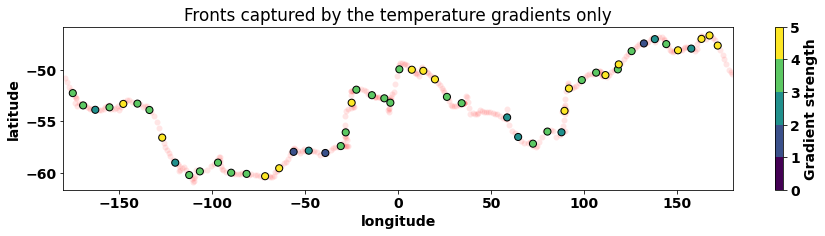

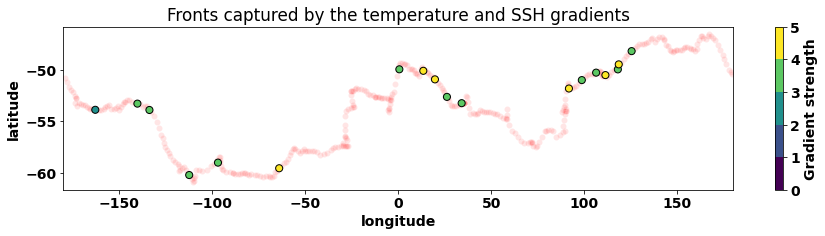

In [41]:
fig, ax = plt.subplots(figsize = (15,3))

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0, len(criterion)+1, 1), cmap.N)

plt.scatter(gdf.longitude, gdf.latitude, c = 'r', label = 'no SSH grad', alpha = .1,
            edgecolors = 'w')
plt.scatter(temp_fronts.longitude, temp_fronts.latitude, c = temp_fronts.level, norm = norm, s = 50,
            edgecolors = 'k')

# CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Gradient strength', ticks = np.arange(0, len(criterion)+1, 1))
plt.title('Fronts captured by the temperature gradients only')
plt.xlim(-180,180)

########################################################
fig, ax = plt.subplots(figsize = (15,3))

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0, len(criterion)+1, 1), cmap.N)

plt.scatter(gdf.longitude, gdf.latitude, c = 'r', label = 'no SSH grad', alpha = .1,
            edgecolors = 'w')
plt.scatter(fronts_jets.longitude, fronts_jets.latitude, c = fronts_jets.level, norm = norm, s = 50,
            edgecolors = 'k')

# CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Gradient strength', ticks = np.arange(0, len(criterion)+1, 1))
plt.title('Fronts captured by the temperature and SSH gradients')
plt.xlim(-180,180)


## Next, we track the fronts related to the SSH gradients and temperature gradients

In [26]:
%time
bol_pos_first = np.ravel([np.array(match_obs_alt(cmems_data.sel(time=str(time_sdrn[t]), method = 'nearest'), 
                                                 gdf.longitude[t], gdf.latitude[t]))
                         for t in range(len(gdf))])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


In [30]:
gdf_gradSSH = gdf.loc[bol_pos_first].copy()
gdf_nogradSSH = gdf.loc[~bol_pos_first].copy()

In [31]:
distance = functions.distFromStart(gdf_gradSSH.latitude.values, gdf_gradSSH.longitude.values)
gdf_gradSSH['distance_km'] = distance

In [32]:
# input the data variable that you want to find fronts with
var = 'TEMP_CTD_RBR_MEAN'

# TO DO: Discuss what criterion we should use for different variables.
# criterion = [0.01, 0.05, 0.25, 0.75, 1] 
criterion = [0, 0.001, 0.0025, 0.005, 0.01] 

temp_fronts_jets = detect_grad_1d(gdf_gradSSH, var, criterion, x_bin = 500, min_obs = False)

(-180.0, 180.0)

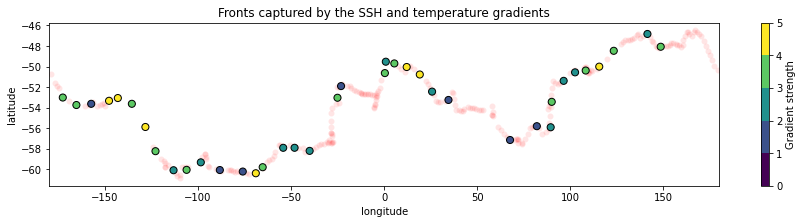

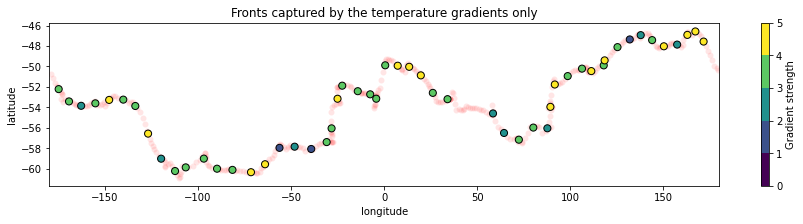

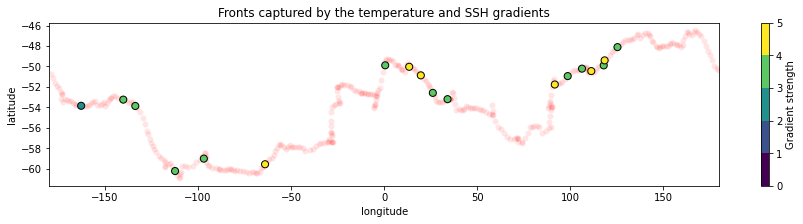

In [45]:
fig, ax = plt.subplots(figsize = (15,3))

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0, len(criterion)+1, 1), cmap.N)

plt.scatter(gdf_nogradSSH.longitude, gdf_nogradSSH.latitude, c = 'r', label = 'no SSH grad', alpha = .1,
            edgecolors = 'w')
plt.scatter(temp_fronts_jets.longitude, temp_fronts_jets.latitude, c = temp_fronts_jets.level, norm = norm, s = 50,
            edgecolors = 'k')

# CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Gradient strength', ticks = np.arange(0, len(criterion)+1, 1))
plt.title('Fronts captured by the SSH and temperature gradients')
plt.xlim(-180,180)

########################################################

fig, ax = plt.subplots(figsize = (15,3))

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0, len(criterion)+1, 1), cmap.N)

plt.scatter(gdf.longitude, gdf.latitude, c = 'r', label = 'no SSH grad', alpha = .1,
            edgecolors = 'w')
plt.scatter(temp_fronts.longitude, temp_fronts.latitude, c = temp_fronts.level, norm = norm, s = 50,
            edgecolors = 'k')

# CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Gradient strength', ticks = np.arange(0, len(criterion)+1, 1))
plt.title('Fronts captured by the temperature gradients only')
plt.xlim(-180,180)

########################################################
fig, ax = plt.subplots(figsize = (15,3))

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0, len(criterion)+1, 1), cmap.N)

plt.scatter(gdf.longitude, gdf.latitude, c = 'r', label = 'no SSH grad', alpha = .1,
            edgecolors = 'w')
plt.scatter(fronts_jets.longitude, fronts_jets.latitude, c = fronts_jets.level, norm = norm, s = 50,
            edgecolors = 'k')

# CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Gradient strength', ticks = np.arange(0, len(criterion)+1, 1))
plt.title('Fronts captured by the temperature and SSH gradients')
plt.xlim(-180,180)
